### Hot Jupiter Case Study: WASP-17b

We'll be simulating cloudy transmission spectra for a hot Jupiter called WASP-17b ($T_{\rm{eq}} = 1700$ K).

WASP-17b is an ideal hot Jupiter to study exoplanet clouds because of the recent discovery of a direct detection of quartz ($\rm{SiO_2}$) clouds from JWST MIRI mid-infrared transmission spectra ([Grant et al. 2023](https://ui.adsabs.harvard.edu/abs/2023ApJ...956L..32G/abstract)). This means WASP-17b is hot enough for mineral clouds to form!

First, we'll define the planet properties that we will be using for the rest of the notebook. 

In [1]:
from POSEIDON.core import create_star, create_planet, wl_grid_constant_R
from POSEIDON.constants import R_Sun, R_J, M_J

import numpy as np
import scipy.constants as sc 

#***** Define stellar properties *****#

R_s = 1.49*R_Sun     # Stellar radius (m)
T_s = 6550           # Stellar effective temperature (K)
Met_s = -0.25        # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.2        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

#***** Define planet properties *****#

planet_name = 'WASP-17b'  # Planet name used for plots, output files etc.

R_p = 1.87*R_J                    # Planetary radius (m)
M_p = 0.78*M_J                    # Planetary mass (kg)
g_p = (sc.G*M_p)/(R_p**2)         # Gravitational field of planet (m/s^2)
T_eq = 1447                       # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, gravity = g_p, T_eq = T_eq)

# Initialise wavelength grid
wl_min = 0.2      # Minimum wavelength (um)
wl_max = 13.0     # Maximum wavelength (um)
R = 10000         # Spectral resolution of grid (R = wl/dwl)

wl = wl_grid_constant_R(wl_min, wl_max, R)

# Specify the pressure grid of the atmosphere
P_min = 1.0e-7    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1.0e-2    # Reference pressure (bar)
R_p_ref = R_p     # Radius at reference pressure

Read the gas-phase opacities.

In [2]:
from POSEIDON.clouds import load_aerosol_grid, interpolate_sigma_Mie_grid

species = 'SiO2'

# Load in the aerosol grid 
aerosol_grid = load_aerosol_grid([species])

# Specify mean radius of the aerosol particles
r_m = 0.01

# Loads effective extinction cross section
sigma_Mie_interp_array = interpolate_sigma_Mie_grid(aerosol_grid, wl, [r_m], [species],)

# Extract the cross sections, asymmetry parameter, and single scattering albedo 
eff_ext = sigma_Mie_interp_array[species]['eff_ext']
eff_w = sigma_Mie_interp_array[species]['eff_w']
eff_g = sigma_Mie_interp_array[species]['eff_g']

Reading in database for aerosol cross sections...


Let's plot the effective extinction cross section for $\rm{SiO_2}$.

The effective extinction cross section encodes the loss of photons to the beam due to the combination of absorption and scattering. This quantity is especially useful for transmission spectra, since a significant fraction of scattered radiation will be directed out of the line of sight to a distant observer.

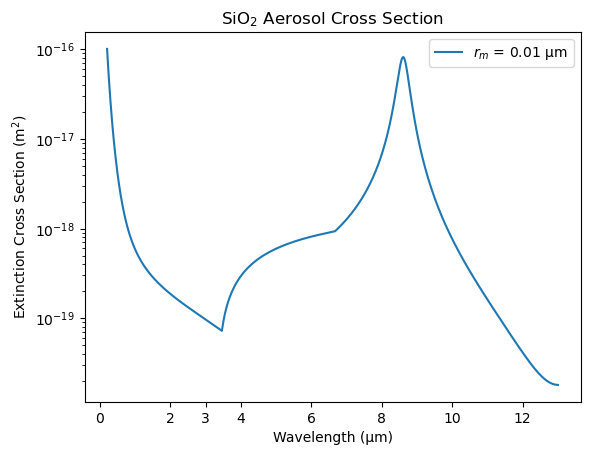

In [3]:
import matplotlib.pyplot as plt

label = '$r_m$ = ' + str(r_m) + ' μm'
title = 'SiO$_2$ Aerosol Cross Section'

plt.semilogy(wl, eff_ext, label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelength (μm)')
plt.ylabel('Extinction Cross Section (m$^2$)')
plt.xticks((0,2,3,4,6,8,10,12))
plt.show()

Let's now create an atmosphere using the fuzzy deck model.

In [4]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'Fuzzy_Deck_SiO2'

bulk_species = ['H2', 'He']
param_species = ['H2O']

# Set aerosol species
aerosol_species = ['SiO2']  # <---- Put aerosol species here

# Define model
model_fuzzy_deck = define_model(model_name, bulk_species, param_species,
                                PT_profile = 'isotherm', X_profile = 'isochem',
                                cloud_model = 'Mie',                 # <---- Put cloud model here (Mie)
                                cloud_type = 'fuzzy_deck',           # <---- Put cloud type here 
                                aerosol_species = aerosol_species,   # <---- Put aerosol species list here 
                                )   


# Check the free parameters defining this model
print("PT parameters : " + str(model_fuzzy_deck['PT_param_names']))
print("X parameters : " + str(model_fuzzy_deck['X_param_names']))
print("Cloud parameters : " + str(model_fuzzy_deck['cloud_param_names'])) # <---- Print the cloud param names

PT parameters : ['T']
X parameters : ['log_H2O']
Cloud parameters : ['log_P_top_deck_SiO2' 'log_r_m_SiO2' 'log_n_max_SiO2' 'f_SiO2']


In [5]:
from POSEIDON.core import read_opacities

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# First, specify limits of the fine temperature and pressure grids for the 
# pre-interpolation of cross sections. These fine grids should cover a
# wide range of possible temperatures and pressures for the model atmosphere.

# Define fine temperature grid (K)
T_fine_min = 400     # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 2000    # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 20     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model_fuzzy_deck, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2O done
Reading in database for aerosol cross sections...
Opacity pre-interpolation complete.


In [6]:
from POSEIDON.core import make_atmosphere

# PT and X parameters
T = 1200
log_H2O = -4

# Cloud Parameters 
log_P_top_deck_SiO2 = 0     # <---- Top of the opaque deck is at 1 bar (extends from 100 to 1 bar)
log_r_m_SiO2        = -2    # <---- Mean particle size of the SiO2 aerosols is 1e-2 microns
log_n_max_SiO2      = 20    # <---- The number density of SiO2 at the top of the opaque deck (at 1 bar)
f_SiO2              = 0.3   # <---- The fuzziness of aerosols (how number density evolves above the cloud deck)

PT_params = np.array([T])
log_X_params = np.array([log_H2O])
cloud_params = np.array([log_P_top_deck_SiO2, log_r_m_SiO2, log_n_max_SiO2, f_SiO2])

# Make atmosphere 
atmosphere_fuzzy_deck = make_atmosphere(planet, model_fuzzy_deck, P, P_ref, R_p_ref, 
                                        PT_params, log_X_params, cloud_params)

And finally, we can make a spectrum using Mie scattering!

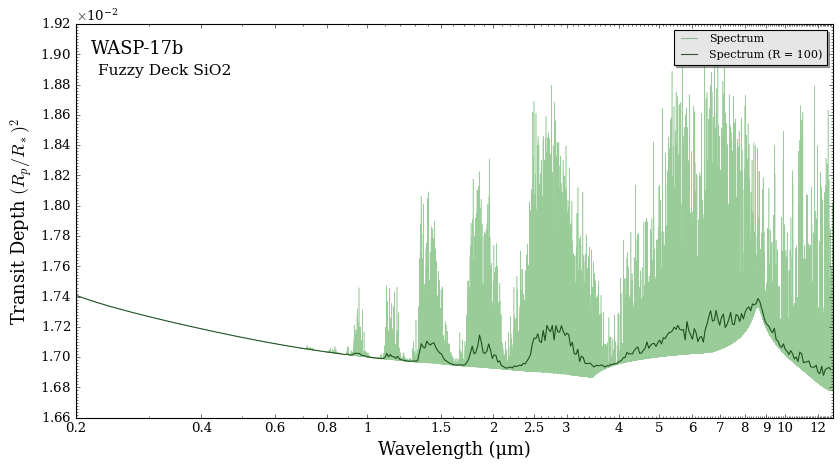

In [7]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate spectrum
spectrum_fuzzy_deck = compute_spectrum(planet, star, model_fuzzy_deck, 
                                       atmosphere_fuzzy_deck, opac, wl,
                                       spectrum_type = 'transmission')
# Plot spectrum
spectra = plot_collection(spectrum_fuzzy_deck, wl, collection = [])

fig = plot_spectra(spectra, planet, R_to_bin = 100,
                   plt_label = 'Fuzzy Deck SiO2',
                   save_fig = False,
                   figure_shape = 'wide',
                   ) 

Aha! I spy an absorption feature near 8-9 μm!

Let's analyse what is happening using our favourite spectral decomposition helper function. 🔍

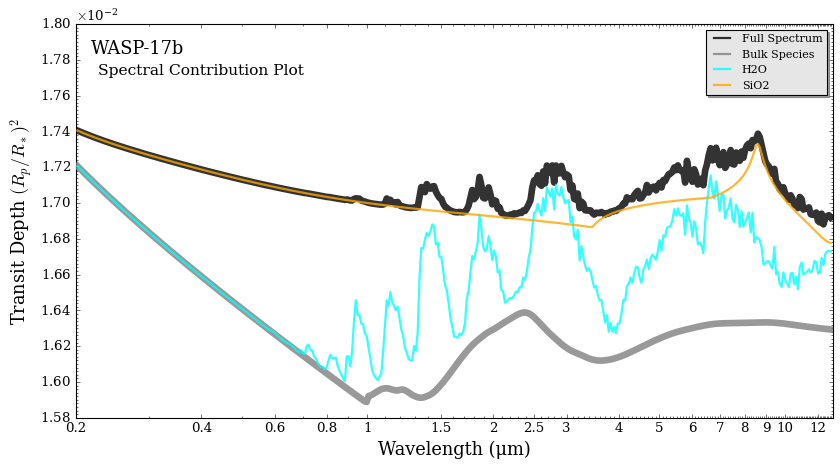

In [8]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, \
spectrum_contribution_list = spectral_contribution(planet, star, model_fuzzy_deck, 
                                                   atmosphere_fuzzy_deck, opac, wl,
                                                   contribution_species_list = ['H2O'],
                                                   cloud_species_list = ['SiO2'],
                                                   bulk_species = True, 
                                                   cloud_contribution = True,
                                                   )

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, 
                                 spectrum_contribution_list,
                                 return_fig = True,
                                 line_widths = [6,6,2,2],
                                 colour_list = ['black', 'gray', 'cyan', 'orange'],
                                 y_min = 1.58e-2, y_max = 1.80e-2,
                                 )

In [9]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'Slab_SiO2'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']
aerosol_species = ['SiO2']

model_slab = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',               # <---- Put cloud model here (Mie)
                     cloud_type = 'slab',               # <---- Put cloud type here 
                     aerosol_species = aerosol_species) # <---- Put aerosol species list here 


# Check the free parameters defining this model
print("PT parameters : " + str(model_slab['PT_param_names']))
print("X parameters : " + str(model_slab['X_param_names']))
print("Cloud parameters : " + str(model_slab['cloud_param_names']))  # <---- Print the cloud param names


PT parameters : ['T']
X parameters : ['log_H2O']
Cloud parameters : ['log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2' 'log_X_SiO2']


In [10]:
from POSEIDON.core import make_atmosphere

# PT and X parameters
T = 1200
log_H2O = -4

# Cloud Parameters 
log_P_top_slab_SiO2 = -5  # <---- The top of the slab in pressure space (at 1e-5 bars)
Delta_log_P_SiO2    = 2   # <---- Extend of the slab in pressure space (extends down to 1e-3 bars)
log_r_m_SiO2        = -2  # <---- Mean particle size of the SiO2 aerosols is 1e-2 microns
log_X_SiO2          = -12 # <---- Volume mixing ratio of aerosol in the slab (1e-5 to 1e-3 bars)

PT_params = np.array([T])
log_X_params = np.array([log_H2O])
cloud_params = ([log_P_top_slab_SiO2,Delta_log_P_SiO2,log_r_m_SiO2,log_X_SiO2])

# Make atmosphere 
atmosphere_slab = make_atmosphere(planet, model_slab, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

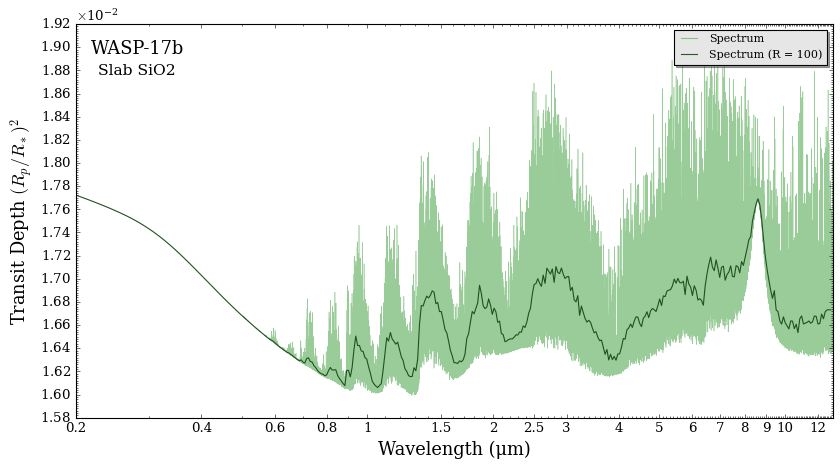

In [11]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate spectrum
spectrum_slab = compute_spectrum(planet, star, model_slab, atmosphere_slab, opac, wl,
                                      spectrum_type = 'transmission')
# Plot spectrum
spectra = plot_collection(spectrum_slab, wl, collection = [])

fig = plot_spectra(spectra, planet, R_to_bin = 100,
                   plt_label = 'Slab SiO2',
                   save_fig = False,
                   figure_shape = 'wide') 

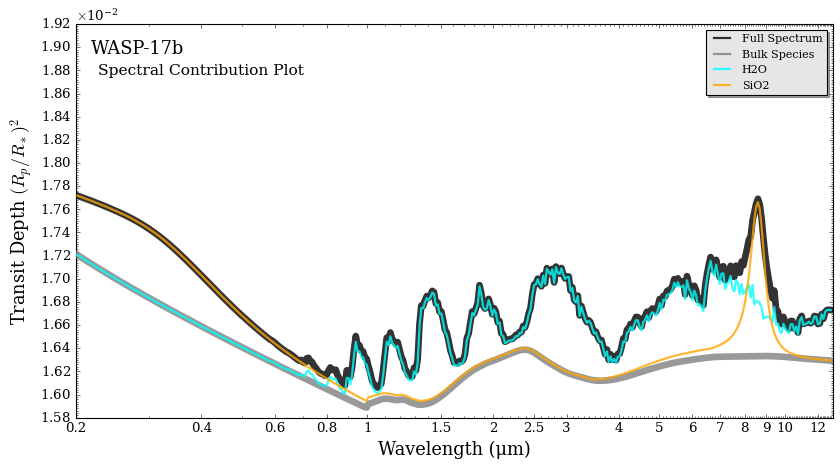

In [12]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star,  model_slab, atmosphere_slab, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True,)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange'])

In [13]:
model_name = 'Uniform_X'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']
aerosol_species = ['SiO2'] # <---- Put aerosol species here

model_uniform_x = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',               # <---- Put cloud model here (Mie)
                     cloud_type = 'uniform_X',          # <---- Put cloud type here 
                     aerosol_species = aerosol_species) # <---- Put aerosol species list here 

print()
print("Cloud parameters (Uniform X) : " + str(model_uniform_x['cloud_param_names'])) # <---- Print the cloud param names


Cloud parameters (Uniform X) : ['log_r_m_SiO2' 'log_X_SiO2']


In [14]:
model_name = 'Uniform_X'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']
aerosol_species = ['SiO2', 'MgSiO3'] # <---- Put aerosol species here

model_uniform_x_two = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',               # <---- Put cloud model here (Mie)
                     cloud_type = 'uniform_X',          # <---- Put cloud type here 
                     aerosol_species = aerosol_species) # <---- Put aerosol species list here 

print()
print("Cloud parameters (Uniform X) : " + str(model_uniform_x_two['cloud_param_names'])) # <---- Print the cloud param names

# If you are changing aerosol-species you will need to make a new opac object, or use the followng forward model functionality 

from POSEIDON.clouds import switch_aerosol_in_opac

opac_sio2_mgsio3 = switch_aerosol_in_opac(model_uniform_x_two,opac)


Cloud parameters (Uniform X) : ['log_r_m_SiO2' 'log_X_SiO2' 'log_r_m_MgSiO3' 'log_X_MgSiO3']
Reading in database for aerosol cross sections...


In [15]:
from POSEIDON.core import make_atmosphere

T = 1200
log_H2O = -4

PT_params = np.array([T])
log_X_params = np.array([log_H2O])

log_r_m_SiO2        = -2  # <---- Mean particle size of the SiO2 aerosols is 1e-2 microns
log_X_SiO2          = -12 # <---- Volume mixing ratio of aerosol throughout the entire atmosphere

cloud_params = ([log_r_m_SiO2, log_X_SiO2])
                 
atmosphere_uniform_x = make_atmosphere(planet, model_uniform_x, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

log_r_m_SiO2        = -2     # <---- Mean particle size of the SiO2 aerosols is 1e-2 microns
log_X_SiO2          = -12    # <---- Volume mixing ratio of aerosol throughout the entire atmosphere
log_r_m_MgSiO3        = -2.5 # <---- Mean particle size of the MgSiO3 aerosols is 1e-2.5 microns
log_X_MgSiO3          = -10  # <---- Volume mixing ratio of aerosol throughout the entire atmosphere

cloud_params = ([log_r_m_SiO2, log_X_SiO2, log_r_m_MgSiO3, log_X_MgSiO3])
                 
atmosphere_uniform_x_two = make_atmosphere(planet, model_uniform_x_two, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)


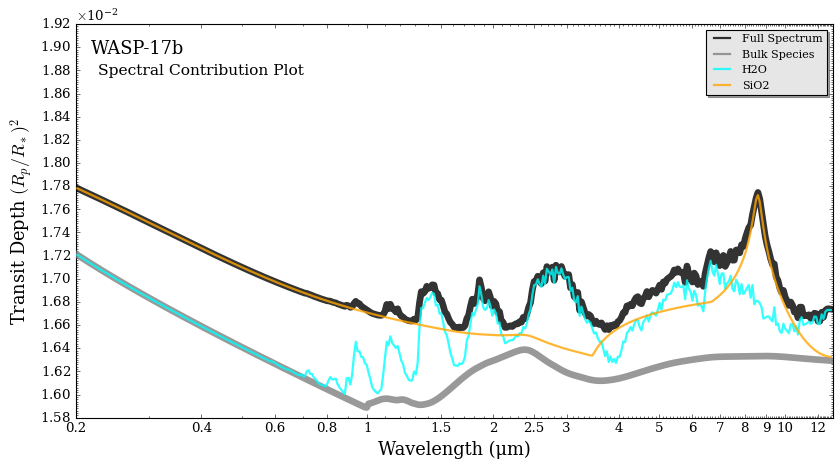

In [16]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_uniform_x,atmosphere_uniform_x, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True,)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange'])

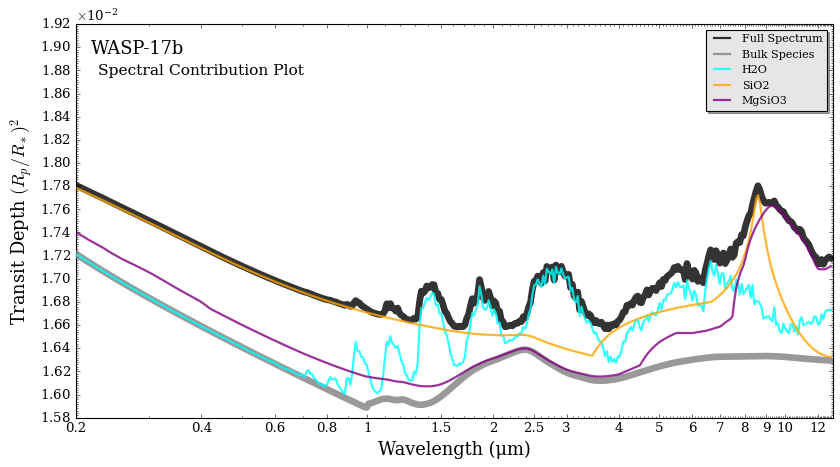

In [17]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_uniform_x_two,atmosphere_uniform_x_two, opac_sio2_mgsio3, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2', 'MgSiO3'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True,)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange', 'purple'])

#### Advanced: Hybrid Slab and Fuzzy Deck Models

You can define multiple slabs where each aerosol is a seperate slab in the model. 

We can also combine a slab with an opaque deck, and combine a slab and a fuzzy deck model.

In [18]:
model_name = 'Multiple_Slabs'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']

aerosol_species = ['SiO2', 'MgSiO3'] # <---- Put aerosol species here

model_multiple_slabs = define_model(model_name, bulk_species, param_species,
                                    PT_profile = 'isotherm', X_profile = 'isochem',
                                    cloud_model = 'Mie',cloud_type = 'slab', # <---- Put cloud type here 
                                    aerosol_species = aerosol_species) # <---- Put aerosol species list here 

model_name = 'Opaque_deck_plus_slab'

model_opaque_plus_slabs = define_model(model_name, bulk_species, param_species,
                                        PT_profile = 'isotherm', X_profile = 'isochem',
                                        cloud_model = 'Mie',cloud_type = 'opaque_deck_plus_slab', # <---- Put cloud type here 
                                        aerosol_species = aerosol_species) # <---- Put aerosol species list here 

model_name = 'Fuzzy_deck_plus_slab'
aerosol_species = ['Fe','SiO2', 'MgSiO3'] # <---- Put aerosol species here

model_fuzzy_deck_plus_slabs = define_model(model_name, bulk_species, param_species,
                                            PT_profile = 'isotherm', X_profile = 'isochem',
                                            cloud_model = 'Mie',cloud_type = 'fuzzy_deck_plus_slab', # <---- Put cloud type here 
                                            aerosol_species = aerosol_species) # <---- Put aerosol species list here 

print()
print("Cloud parameters (slabs) : " + str(model_multiple_slabs['cloud_param_names']))
print()
print("Cloud parameters (opaque deck + slabs) : " + str(model_opaque_plus_slabs['cloud_param_names']))
print()
print("Cloud parameters (fuzzy deck + slabs) : " + str(model_fuzzy_deck_plus_slabs['cloud_param_names']))

This mode assumes that the first aerosol in the list is the deck species, rest are slab species

Cloud parameters (slabs) : ['log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2' 'log_X_SiO2'
 'log_P_top_slab_MgSiO3' 'Delta_log_P_MgSiO3' 'log_r_m_MgSiO3'
 'log_X_MgSiO3']

Cloud parameters (opaque deck + slabs) : ['log_P_top_deck' 'log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2'
 'log_X_SiO2' 'log_P_top_slab_MgSiO3' 'Delta_log_P_MgSiO3'
 'log_r_m_MgSiO3' 'log_X_MgSiO3']

Cloud parameters (fuzzy deck + slabs) : ['log_P_top_deck_Fe' 'log_r_m_Fe' 'log_n_max_Fe' 'f_Fe'
 'log_P_top_slab_SiO2' 'Delta_log_P_SiO2' 'log_r_m_SiO2' 'log_X_SiO2'
 'log_P_top_slab_MgSiO3' 'Delta_log_P_MgSiO3' 'log_r_m_MgSiO3'
 'log_X_MgSiO3']


In [19]:
# Here I load in a new opac for experimenting

from POSEIDON.core import read_opacities

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# First, specify limits of the fine temperature and pressure grids for the 
# pre-interpolation of cross sections. These fine grids should cover a
# wide range of possible temperatures and pressures for the model atmosphere.

# Define fine temperature grid (K)
T_fine_min = 400     # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 2000    # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 20     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac_fe_sio2_mgsio3 = read_opacities(model_fuzzy_deck_plus_slabs, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2O done
Reading in database for aerosol cross sections...
Opacity pre-interpolation complete.


Let's define our two slabs ($\rm{SiO_2}$ and $\rm{MgSiO_3}$) to have different properties:

In [20]:
from POSEIDON.core import make_atmosphere

T = 1200
log_H2O = -4

PT_params = np.array([T])
log_X_params = np.array([log_H2O])

# Slabs 
log_P_top_slab_SiO2 = -5
Delta_log_P_SiO2    = 1
log_r_m_SiO2        = -2
log_X_SiO2          = -12

log_P_top_slab_MgSiO3 = - 3
Delta_log_P_MgSiO3    = 1
log_r_m_MgSiO3        = -2
log_X_MgSiO3          = -13

cloud_params = ([log_P_top_slab_SiO2, Delta_log_P_SiO2, log_r_m_SiO2, log_X_SiO2, 
                 log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3,log_X_MgSiO3])
                 
atmosphere_multiple_slabs = make_atmosphere(planet, model_multiple_slabs, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)


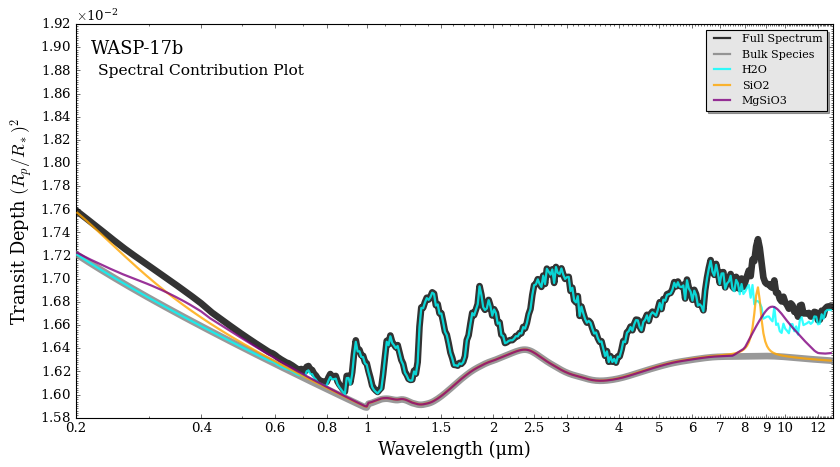

In [34]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_multiple_slabs,atmosphere_multiple_slabs, opac_sio2_mgsio3, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2', 'MgSiO3'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True,)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange', 'purple'])

Now let's add an opaque deck to our multiple slab model (spanning $100$ to $10^{-2}$ bars)

In [22]:
# Opaque + Slabs
log_P_top_deck        = -2

cloud_params = ([log_P_top_deck,
                 log_P_top_slab_SiO2,Delta_log_P_SiO2,log_r_m_SiO2,log_X_SiO2,
                 log_P_top_slab_MgSiO3,Delta_log_P_MgSiO3, log_r_m_MgSiO3,log_X_MgSiO3])

atmosphere_opaque_plus_slabs = make_atmosphere(planet, model_opaque_plus_slabs, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

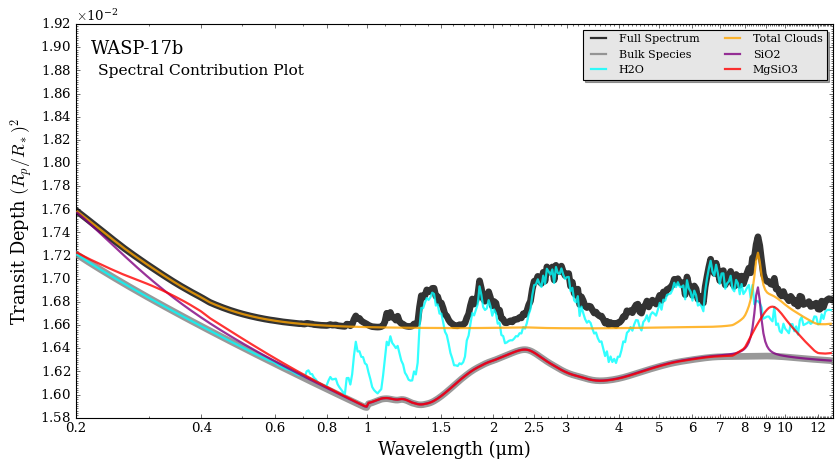

In [23]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_opaque_plus_slabs,atmosphere_opaque_plus_slabs, opac_sio2_mgsio3, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2', 'MgSiO3'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            cloud_total_contribution = True,)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange', 'purple', 'red'])

We can make the opaque deck a fuzzy iron deck instead:

In [24]:
# Fuzzy Deck + Slabs
log_P_top_deck_Fe     = 0
log_r_m_Fe            = -2
log_n_max_Fe          = 20
f_Fe                  = 0.2


cloud_params = ([log_P_top_deck_Fe,log_r_m_Fe,log_n_max_Fe,f_Fe,
                 log_P_top_slab_SiO2,Delta_log_P_SiO2,log_r_m_SiO2,log_X_SiO2,
                 log_P_top_slab_MgSiO3,Delta_log_P_MgSiO3,log_r_m_MgSiO3,log_X_MgSiO3])

atmosphere_fuzzy_deck_plus_slabs = make_atmosphere(planet, model_fuzzy_deck_plus_slabs, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

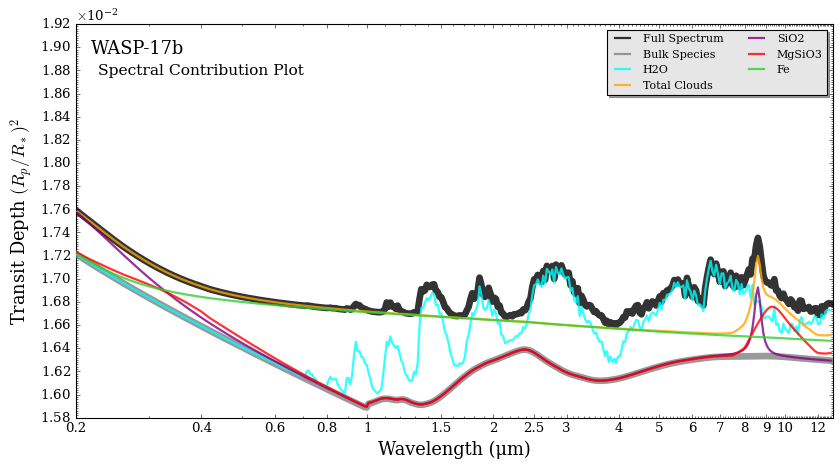

In [25]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_fuzzy_deck_plus_slabs,atmosphere_fuzzy_deck_plus_slabs, opac_fe_sio2_mgsio3, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2', 'MgSiO3', 'Fe'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            cloud_total_contribution = True,)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2,2,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange', 'purple', 'red', 'limegreen'])

There is also an option to define a slab so that multiple aerosol species share the same pressure extent, but differ in mixing ratio and radii — this is good for retrievals since it decreases the number of parameters.

In [26]:
model_name = 'One_Slab_Multiple_Species'

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']

aerosol_species = ['SiO2', 'MgSiO3']

model_one_slab_multiple_species = define_model(model_name, bulk_species, param_species,
                                                PT_profile = 'isotherm', X_profile = 'isochem',
                                                cloud_model = 'Mie',cloud_type = 'one_slab',
                                                aerosol_species = aerosol_species)

print("Cloud parameters (One Slab, Multiple Species) : " + str(model_one_slab_multiple_species['cloud_param_names']))

Cloud parameters (One Slab, Multiple Species) : ['log_P_top_slab' 'Delta_log_P' 'log_r_m_SiO2' 'log_X_SiO2'
 'log_r_m_MgSiO3' 'log_X_MgSiO3']


In [27]:
from POSEIDON.core import make_atmosphere

T = 1200
log_H2O = -4

PT_params = np.array([T])
log_X_params = np.array([log_H2O])

# Slab with multiple species
log_P_top_slab = -5
Delta_log_P    = 2
log_r_m_SiO2        = -2
log_X_SiO2          = -12
log_r_m_MgSiO3        = -1.5
log_X_MgSiO3          = -13

cloud_params = ([log_P_top_slab, Delta_log_P, log_r_m_SiO2, log_X_SiO2, log_r_m_MgSiO3,log_X_MgSiO3])
                 
atmosphere_one_slab_multiple_species = make_atmosphere(planet, model_one_slab_multiple_species, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

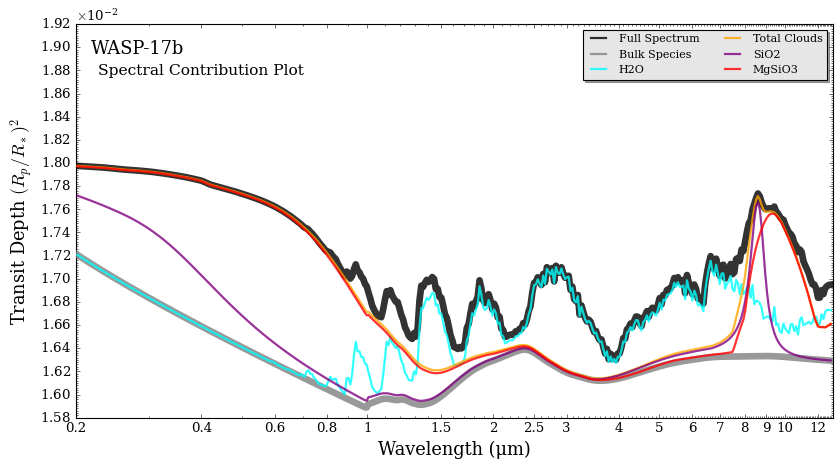

In [28]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_one_slab_multiple_species,atmosphere_one_slab_multiple_species, opac_sio2_mgsio3, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            cloud_species_list = ['SiO2', 'MgSiO3',],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            cloud_total_contribution = True,)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange', 'purple', 'red'])

In [29]:
bulk_species = ['H2', 'He']     
param_species = ['H2O']

model_name = 'File_Read'
aerosol_species = ['file_read'] # <---- Put file_read here for using your own refractive index txt file

model_file_read = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',cloud_type = 'uniform_X',
                     aerosol_species = aerosol_species)

model_name = 'Free'
aerosol_species = ['free'] # <---- Put free here for constant real and imaginary refractive index
model_free = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', X_profile = 'isochem',
                     cloud_model = 'Mie',cloud_type = 'uniform_X',
                     aerosol_species = aerosol_species)

print()
print("Cloud parameters (File Read) : " + str(model_file_read['cloud_param_names']))
print()
print("Cloud parameters (Free) : " + str(model_free['cloud_param_names']))


Cloud parameters (File Read) : ['log_r_m' 'log_X_Mie' 'r_i_real' 'r_i_complex']

Cloud parameters (Free) : ['log_r_m' 'log_X_Mie' 'r_i_real' 'r_i_complex']


Let's look at the file read first

In [30]:
from POSEIDON.clouds import load_refractive_indices_from_file

T = 1200
log_H2O = -4

PT_params = np.array([T])
log_X_params = np.array([log_H2O])

# Cloud Params 
log_r_m            = -2  # <---- Mean particle size of aerosol (1e-2 um)
log_X_Mie          = -12 # <---- Mixing ratio of aerosol throughout whole atmosphere

# Preload the refractive indices from the file 
refractive_index_path = '../../../POSEIDON/reference_data/refractive_indices_txt_files/aerosol_database/WS15/'
file_name = refractive_index_path + 'H2O_complex.txt'

r_i_real, r_i_complex = load_refractive_indices_from_file(wl, file_name) # <---- Load in the real and imaginary indices

cloud_params = ([log_r_m, log_X_Mie, r_i_real, r_i_complex])

atmosphere_file_read = make_atmosphere(planet, model_file_read, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

Loading in :  ../../../POSEIDON/reference_data/refractive_indices_txt_files/aerosol_database/WS15/H2O_complex.txt


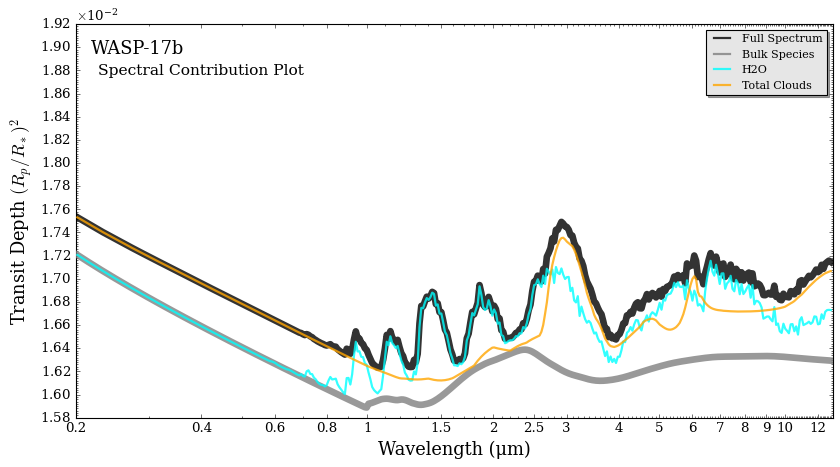

In [31]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_file_read,atmosphere_file_read, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            cloud_total_contribution = True,)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange'])

Now let's look at the constant refractive index with wavelength

In [32]:
# Constant refractive indices 
r_i_real, r_i_complex = 1, 1e-3 # <---- real refractive index, imaginary refractive index

cloud_params = ([log_r_m, log_X_Mie, r_i_real, r_i_complex])

atmosphere_free = make_atmosphere(planet, model_free, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params)

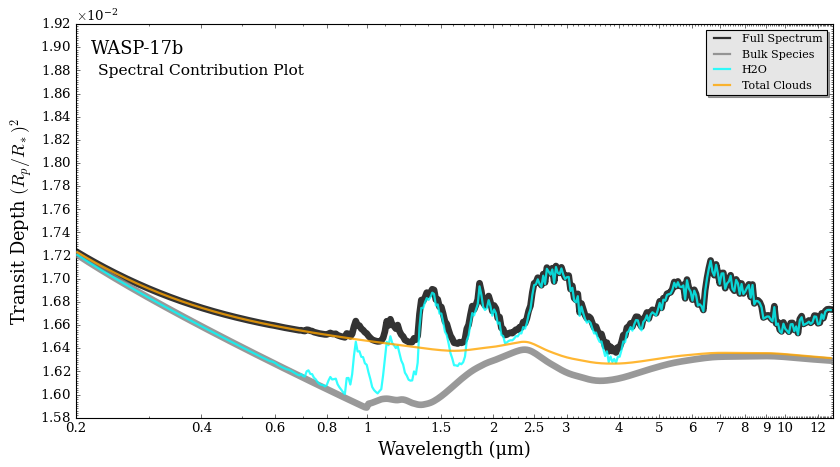

In [35]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

spectrum, spectrum_contribution_list_names, spectrum_contribution_list = spectral_contribution(planet, star, model_free,atmosphere_free, opac, wl,
                                                                                            contribution_species_list = ['H2O'],
                                                                                            bulk_species = True, 
                                                                                            cloud_contribution = True, 
                                                                                            cloud_total_contribution = True,)

fig = plot_spectral_contribution(planet, wl, spectrum, spectrum_contribution_list_names, spectrum_contribution_list,
                           return_fig = True,
                           line_widths = [6,6,2,2],
                           colour_list = ['black', 'gray', 'cyan', 'orange'])